# LSTM 时序预测
时间：2021-8-12 ， 数据：请求表数据.csv<br>

链接：<br>
[1]https://nbviewer.jupyter.org/github/Schlam/LSTM-time-series-forecasting/blob/master/lstm_300_epochs.ipynb 多目标的预测<br>
[2] https://github.com/search?q=Time+Series+transformer&type=Repositories <br>
[3]https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/3_RNN_encoder_decoder.ipynb <br>
[4] https://github.com/philipperemy/keras-attention-mechanism tf2.0 lstm中添加了 attention<br>
  
  
## tricks：
(1) 使用 3 个时间段预测未来一天 <br>

## 数据导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [2]:
#将时间序列做为索引
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')

data = pd.read_csv('../data/请求表预估08_09_2021.csv',
                   parse_dates=True,
                   date_parser=dateparse,
                   index_col='dt',
                   encoding='utf-8',
                   engine='python'
                  )

data = data[1:49]
print('数据长度:', len(data))
data.head()

数据长度: 48


/home/luban/miniconda3/envs/tf20/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


impression
dt                    
2021-05-18   228695188
2021-05-19   232430656
2021-05-20   244480422
2021-05-21   268542497
2021-05-22   254063058

In [32]:
# 将时间序列的数据转化成有监督学习的训练集
def series_to_supervised(data, n_in=3, n_out=1, dropnan=True):
    """
    :param data:  原始时间序列数据
    :param n_in:  训练样本的特征维度
    :param n_out: 训练样本的标签
    :param dropnan: 是否删除na的样本
    :return: 监督学习的训练样本
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return pd.DataFrame(agg.values, index=data.index[:len(data)-n_in-n_out +1])



In [52]:
n_in=7 # 设置使用前多少天
n_out=1 # 设置往后预测几天
dat = series_to_supervised(data, n_in, n_out)
print(len(dat))
dat.head()

41


0            1            2            3            4  \
dt                                                                            
2021-05-18  228695188.0  232430656.0  244480422.0  268542497.0  254063058.0   
2021-05-19  232430656.0  244480422.0  268542497.0  254063058.0  226762069.0   
2021-05-20  244480422.0  268542497.0  254063058.0  226762069.0  216801204.0   
2021-05-21  268542497.0  254063058.0  226762069.0  216801204.0  226055523.0   
2021-05-22  254063058.0  226762069.0  216801204.0  226055523.0  233257635.0   

                      5            6            7  
dt                                                 
2021-05-18  226762069.0  216801204.0  226055523.0  
2021-05-19  216801204.0  226055523.0  233257635.0  
2021-05-20  226055523.0  233257635.0  235315498.0  
2021-05-21  233257635.0  235315498.0  264631022.0  
2021-05-22  235315498.0  264631022.0  251421708.0

## 切片，归一化处理

In [53]:
# 归一化处理
"""
### Clean data by scaling each feature down to (0, 1)
"""
def normalize_cols(df, cols):
    """Scale the values of each feature
    according to the columns max value"""
    data = df.loc[:,cols]
    for col in cols:
        scaler = lambda x: x / data[col].max()
        data[col] = data[col].apply(scaler)
    print(data[cols].head())
    return data[cols].values


features = dat.columns.values[:] # columns to train model on
X = normalize_cols(dat, features)

                   0         1         2         3         4         5  \
dt                                                                       
2021-05-18  0.851616  0.865527  0.910398  1.000000  0.960065  0.856899   
2021-05-19  0.865527  0.910398  1.000000  0.946081  0.856899  0.819258   
2021-05-20  0.910398  1.000000  0.946081  0.844418  0.819258  0.854229   
2021-05-21  1.000000  0.946081  0.844418  0.807325  0.854229  0.881445   
2021-05-22  0.946081  0.844418  0.807325  0.841787  0.881445  0.889221   

                   6         7  
dt                              
2021-05-18  0.819258  0.854229  
2021-05-19  0.854229  0.881445  
2021-05-20  0.881445  0.889221  
2021-05-21  0.889221  1.000000  
2021-05-22  1.000000  0.950084  


In [55]:

"""
### Turn each signal into a labeled dataset
"""
split_time = len(dat) - 7  # 将时间序列后 split_time 作为预测值

# X = np.array(data)
x_train = X[:split_time,:]
x_test = X[split_time:,:]

def transform(values):
    return values.reshape(values.shape[0], values.shape[1], 1)

train_x, train_y = transform(x_train[:, : -n_out]), x_train[:, -n_out:]
test_x, test_y  = transform(x_test[:, : -n_out]), x_test[:, -n_out:]


print(f"Training data shape: {train_x.shape}")
print(f"Validation data shape: {test_x.shape}")


Training data shape: (34, 7, 1)
Validation data shape: (7, 7, 1)


## 模型的评价

In [56]:
# 定义mape检验函数
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 选择模型

## 一层LSTM

In [57]:
# 并定义网络结构
model_1 = keras.Sequential()
model_1.add(keras.layers.LSTM(64, input_shape=(train_x.shape[1], train_x.shape[2])))
model_1.add(keras.layers.Dense(n_out))
model_1.add(keras.layers.Activation("linear"))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [58]:
## LSTM 模型
model = model_1

In [59]:
model.compile(loss="mae", optimizer="adam")

In [60]:
history = model.fit(train_x,
                    train_y,
                    validation_data=(test_x, test_y),
                    epochs=100,
                    batch_size=100,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
1/1 [==============================] - 0s 461ms/step - loss: 0.7866 - val_loss: 0.6992
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.7479 - val_loss: 0.6627
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.7091 - val_loss: 0.6260
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6699 - val_loss: 0.5887
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6302 - val_loss: 0.5507
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5898 - val_loss: 0.5118
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5484 - val_loss: 0.4717
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5057 - val_loss: 0.4302
Epoch 9/100
1/1 [==============================] - 0s 23ms/step - loss: 0.4615 - val_loss: 0.3869
Epoch 10/100
1/1 [==============================] - 0s 23ms/step - loss: 0.4154 - val_loss: 0.3415
Epoch 11/100
1/1 [

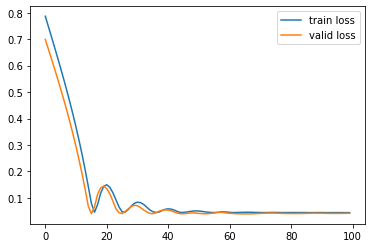

In [61]:
# 训练集和验证集的损失图
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [62]:
# test 集上的 loss
model.evaluate(test_x, test_y , verbose=0)

0.04188075289130211

### 预测值还原

In [63]:
prediction = model.predict(test_x)

max_value = np.max(data.iloc[:,-1])
min_value = np.min(data.iloc[:,-1])
prediction = prediction[:, 0] * (max_value - min_value) + min_value
print(prediction)

# 因为 look_back 处理时会去掉值为 nan 的 input，所以这里要加上 look_back
expectation = dat.iloc[:,-1][split_time:].values
print(expectation)

[2.50202377e+08 2.49302473e+08 2.48252781e+08 2.48276155e+08
 2.48550471e+08 2.47925494e+08 2.47910346e+08]
[1.89400067e+08 1.91099608e+08 2.17866198e+08 2.16771541e+08
 1.96494562e+08 2.04728949e+08 1.98829328e+08]


### 预测结果 绘图

<AxesSubplot:xlabel='dt'>

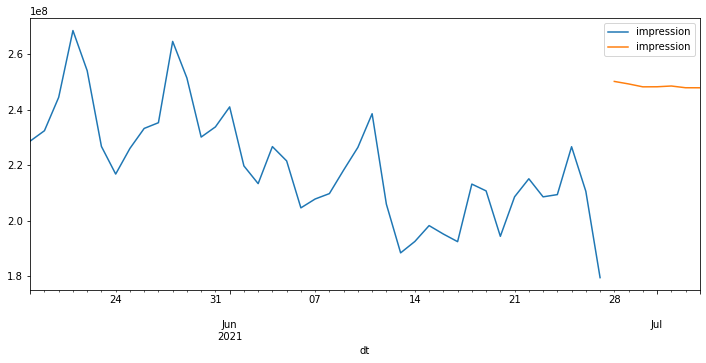

In [65]:

train_data = data.iloc[:split_time+n_in]    #train_data 
test_data = data.iloc[split_time+n_in:]    #test_data


#将预测结果写入到impression
pre = test_data.copy()
pre['impression'] = prediction


#绘图观察时间序列数据
train_data.plot(figsize = (12, 5), legend = True)
pre['impression'].plot(legend = True)

In [67]:
print('MAPE_model ：','%.2f' % mape(expectation, prediction),'%')

MAPE_model ： 23.33 %


## 两层LSTM

In [68]:
# 双层的lstm
model_2 = keras.Sequential()
model_2.add(keras.layers.LSTM(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model_2.add(keras.layers.Dropout(0.2))

model_2.add(keras.layers.LSTM(32, return_sequences=False))
model_2.add(keras.layers.Dropout(0.2))

model_2.add(keras.layers.Dense(1))
model_2.add(keras.layers.Activation("linear"))
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 7, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
__________________________________________________

In [69]:
## LSTM 模型
model = model_2

In [70]:
model.compile(loss="mae", optimizer="adam")

In [71]:
history = model.fit(train_x,
                    train_y,
                    validation_data=(test_x, test_y),
                    epochs=100,
                    batch_size=100,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
1/1 [==============================] - 1s 787ms/step - loss: 0.8203 - val_loss: 0.7268
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.7772 - val_loss: 0.6795
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.7201 - val_loss: 0.6320
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.6732 - val_loss: 0.5839
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 0.6323 - val_loss: 0.5348
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5833 - val_loss: 0.4839
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.5151 - val_loss: 0.4307
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.4692 - val_loss: 0.3743
Epoch 9/100
1/1 [==============================] - 0s 29ms/step - loss: 0.4097 - val_loss: 0.3140
Epoch 10/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3431 - val_loss: 0.2489
Epoch 11/100
1/1 [

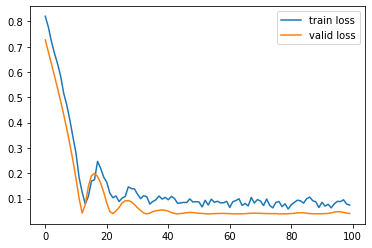

In [72]:
# 训练集和验证集的损失图
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [73]:
# test 集上的 loss
model.evaluate(test_x, test_y , verbose=0)

0.04078945145010948

### 预测值还原

In [74]:
prediction = model.predict(test_x)

max_value = np.max(data.iloc[:,-1])
min_value = np.min(data.iloc[:,-1])
prediction = prediction[:, 0] * (max_value - min_value) + min_value
print(prediction)

# 因为 look_back 处理时会去掉值为 nan 的 input，所以这里要加上 look_back
expectation = dat.iloc[:,-1][split_time:].values
print(expectation)

[2.50097898e+08 2.49528954e+08 2.48603924e+08 2.48272475e+08
 2.48182310e+08 2.47435847e+08 2.47333809e+08]
[1.89400067e+08 1.91099608e+08 2.17866198e+08 2.16771541e+08
 1.96494562e+08 2.04728949e+08 1.98829328e+08]


### 预测结果 绘图

<AxesSubplot:xlabel='dt'>

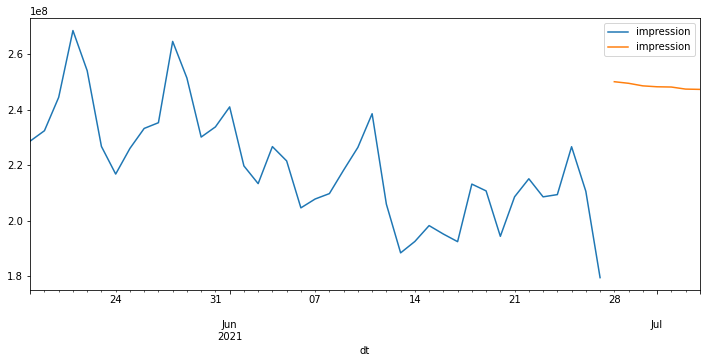

In [75]:

train_data = data.iloc[:split_time+n_in]    #train_data 
test_data = data.iloc[split_time+n_in:]    #test_data


#将预测结果写入到impression
pre = test_data.copy()
pre['impression'] = prediction


#绘图观察时间序列数据
train_data.plot(figsize = (12, 5), legend = True)
pre['impression'].plot(legend = True)

In [76]:
print('MAPE_model ：','%.2f' % mape(expectation, prediction),'%')

MAPE_model ： 23.26 %


## 双向LSTM

In [77]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(train_x.shape[1], train_x.shape[2]))

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add a classifier
outputs = layers.Dense(1, activation="linear")(x)
model_3 = keras.Model(inputs, outputs)
model_3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 128)            33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [78]:
## LSTM 模型
model = model_3

In [79]:
model.compile(loss="mae", optimizer="adam")

In [80]:
history = model.fit(train_x,
                    train_y,
                    validation_data=(test_x, test_y),
                    epochs=100,
                    batch_size=100,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.8048 - val_loss: 0.6621
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.7086 - val_loss: 0.5705
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6109 - val_loss: 0.4747
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 0.5089 - val_loss: 0.3721
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3993 - val_loss: 0.2593
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2790 - val_loss: 0.1326
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1438 - val_loss: 0.0416
Epoch 8/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0450 - val_loss: 0.1470
Epoch 9/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1545 - val_loss: 0.1990
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2097 - val_loss: 0.1947
Epoch 11/100
1/1 [===

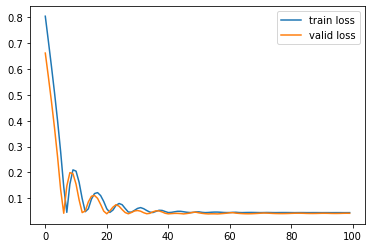

In [81]:
# 训练集和验证集的损失图
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [82]:
# test 集上的 loss
model.evaluate(test_x, test_y , verbose=0)

0.04141896963119507

### 预测值还原

In [83]:
prediction = model.predict(test_x)

max_value = np.max(data.iloc[:,-1])
min_value = np.min(data.iloc[:,-1])
prediction = prediction[:, 0] * (max_value - min_value) + min_value
print(prediction)

# 因为 look_back 处理时会去掉值为 nan 的 input，所以这里要加上 look_back
expectation = dat.iloc[:,-1][split_time:].values
print(expectation)

[2.50088351e+08 2.49298252e+08 2.48380783e+08 2.48627208e+08
 2.48890077e+08 2.48057181e+08 2.48011772e+08]
[1.89400067e+08 1.91099608e+08 2.17866198e+08 2.16771541e+08
 1.96494562e+08 2.04728949e+08 1.98829328e+08]


### 预测结果 绘图

<AxesSubplot:xlabel='dt'>

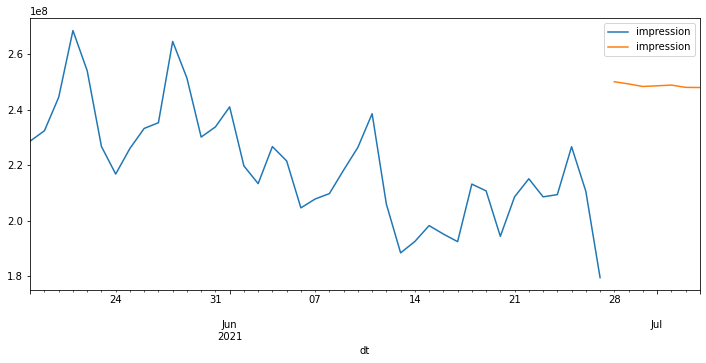

In [84]:

train_data = data.iloc[:split_time+n_in]    #train_data 
test_data = data.iloc[split_time+n_in:]    #test_data


#将预测结果写入到impression
pre = test_data.copy()
pre['impression'] = prediction


#绘图观察时间序列数据
train_data.plot(figsize = (12, 5), legend = True)
pre['impression'].plot(legend = True)

In [85]:
print('MAPE_model ：','%.2f' % mape(expectation, prediction),'%')

MAPE_model ： 23.39 %


# LSTM + series input

下面是使用了 单个series模型， 输入并没有定义batch和sequence的长度，只是定义了输入最后的维度为一维，同时，定义了最后输出的维度，即sequence == 7 ，表示着输出的样本数，也就是预测的样本的个数为7。

训练模型的是任意长度的输入，同时训练数据集中的label必须保证了预测7天的值。
预测样本的输入是任意长度，最后也是预测7天的值。

## 数据导入

In [68]:
data.info()

data_start_date = data.index[0]
data_end_date = data.index[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2021-05-18 to 2021-07-04
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   impression  48 non-null     int64
dtypes: int64(1)
memory usage: 1.8 KB
Data ranges from 2021-05-18 00:00:00 to 2021-07-04 00:00:00


In [99]:
from datetime import timedelta

# 定义预测样本的数据集生成样本
pred_steps = 7
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date)  # 数据集的第一天
last_day = pd.to_datetime(data_end_date)  # 数据集的最后一天

# 训练集
train_enc_start = first_day   # 5-18
train_enc_end = last_day - pred_length - timedelta(1)  # 6-26

train_pred_start = last_day - pred_length  # 6-27
train_pred_end = last_day - timedelta(1)  # 7-3

# 预测
val_enc_start = first_day + timedelta(5) 
val_enc_end = last_day - pred_length

val_pre_start = last_day - pred_length + timedelta(1)
val_pre_end = last_day

       

In [100]:
df = data.T
df

dt          2021-05-18  2021-05-19  2021-05-20  2021-05-21  2021-05-22  \
impression   228695188   232430656   244480422   268542497   254063058   

dt          2021-05-23  2021-05-24  2021-05-25  2021-05-26  2021-05-27  ...  \
impression   226762069   216801204   226055523   233257635   235315498  ...   

dt          2021-06-25  2021-06-26  2021-06-27  2021-06-28  2021-06-29  \
impression   226661202   210599352   179459938   189400067   191099608   

dt          2021-06-30  2021-07-01  2021-07-02  2021-07-03  2021-07-04  
impression   217866198   216771541   196494562   204728949   198829328  

[1 rows x 48 columns]

In [101]:
# 1. 定义时间序列的索引、索引下的值
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[0:]]),
                          data=[i for i in range(len(df.columns[0:]))])
series_array = df[df.columns[0:]].values

In [102]:
# 2.
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date : end_date]
    return series_array[:, inds]

#3.
def transform_series_encode(series_array):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    return series_array

# 将归一化的数据转化成真实数据
def tsf(series_array, encode_series_mean):
    series_array = series_array + encode_series_mean
    series_array = np.expm1(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    return series_array

In [103]:
# latent_dim = 50 # LSTM hidden units
# dropout = .20 

# # Define an input series and encode it with an LSTM. 
# encoder_inputs = Input(shape=(None, 1)) 
# encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# # We discard `encoder_outputs` and only keep the final states. These represent the "context"
# # vector that we use as the basis for decoding.
# encoder_states = [state_h, state_c]

# # Set up the decoder, using `encoder_states` as initial state.
# # This is where teacher forcing inputs are fed in.
# decoder_inputs = Input(shape=(None, 1)) 

# # We set up our decoder using `encoder_states` as initial state.  
# # We return full output sequences and return internal states as well. 
# # We don't use the return states in the training model, but we will use them in inference.
# decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
#                                      initial_state=encoder_states)

# decoder_dense = Dense(1) # 1 continuous output at each timestep
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# model = Model(inputs=[encoder_inputs, decoder_inputs], 
#               outputs=decoder_outputs)
# model.summary()


In [104]:
# 并定义网络结构
inputs = keras.Input(shape=(None, 1)) 
# Add LSTM
x = layers.LSTM(64)(inputs)

outputs = layers.Dense(7, activation="linear")(x)
model_1 = keras.Model(inputs, outputs)
model_1.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 17,351
Trainable params: 17,351
Non-trainable params: 0
_________________________________________________________________


In [105]:
# 并定义网络结构 (两层)
inputs = keras.Input(shape=(None, 1)) 

# Add LSTM
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(32, return_sequences=False)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='linear')(x)

model_2 = keras.Model(inputs, outputs)
model_2.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 29,543
Trainable params: 29,543
Non-trainable params: 0
__________________________________________________

In [106]:
first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
train_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:10000]
train_data, train_data_mean = transform_series_encode(train_data)
train_data.shape  # shape: [none, len_train_seqs , 1]

(1, 40, 1)

In [107]:
# sample of series from train_enc_start to train_enc_end  
train_pre_data = get_time_block_series(series_array, date_to_index, 
                                           train_pred_start, train_pred_end)[:10000]
train_pre_data, train_pre_mean = transform_series_encode(train_pre_data)
train_pre_data.shape  # shape: [none, len_train_seqs , 1]

(1, 7, 1)

In [108]:
# sample of series from train_enc_start to train_enc_end  
val_data = get_time_block_series(series_array, date_to_index, 
                                           val_enc_start, val_enc_end)[:10000]
val_data, val_data_mean = transform_series_encode(val_data)
val_data.shape

(1, 36, 1)

In [109]:
# sample of series from train_enc_start to train_enc_end  
val_pre_data = get_time_block_series(series_array, date_to_index, 
                                           val_pred_start, val_pred_end)[:10000]
val_pre_data, val_pre_mean = transform_series_encode(val_pre_data)
val_pre_data.shape

(1, 7, 1)

In [110]:
model = model_1
model.compile(loss="mae", optimizer="adam")

In [111]:
model.compile(loss="mae", optimizer="adam")
history = model.fit(train_data,
                    train_pre_data,
#                     validation_data=(val_data, val_pre_data),
                    epochs=100,
                    batch_size=100,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 2/100
1/1 [==============================] - 0s 833us/step - loss: 0.0540
Epoch 3/100
1/1 [==============================] - 0s 788us/step - loss: 0.0485
Epoch 4/100
1/1 [==============================] - 0s 880us/step - loss: 0.0427
Epoch 5/100
1/1 [==============================] - 0s 810us/step - loss: 0.0374
Epoch 6/100
1/1 [==============================] - 0s 890us/step - loss: 0.0319
Epoch 7/100
1/1 [==============================] - 0s 818us/step - loss: 0.0292
Epoch 8/100
1/1 [==============================] - 0s 795us/step - loss: 0.0262
Epoch 9/100
1/1 [==============================] - 0s 940us/step - loss: 0.0226
Epoch 10/100
1/1 [==============================] - 0s 789us/step - loss: 0.0178
Epoch 11/100
1/1 [==============================] - 0s 799us/step - loss: 0.0166
Epoch 12/100
1/1 [==============================] - 0s 767us/step - loss: 0.0159
Epoch 13/100
1/1 [=====================

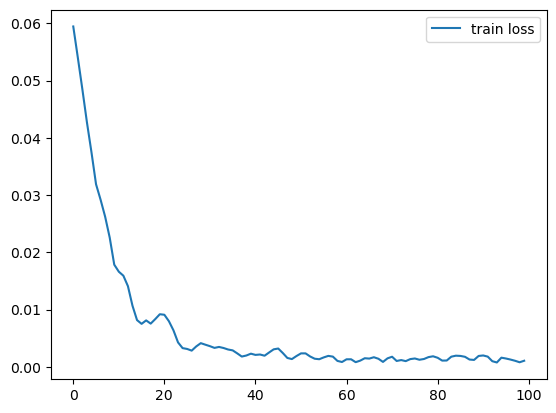

In [112]:
# 训练集和验证集的损失图
plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

## 数据预测

In [119]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
len(encoder_input_data[0])

36

In [117]:
states_value = model.predict(encoder_input_data)
states_value

array([[-0.09787102, -0.04835907, -0.03827339,  0.08998228,  0.08234392,
        -0.00896369,  0.03040298]], dtype=float32)

In [115]:
tsf(states_value, train_data_mean)

array([[[1.99754554e+08],
        [2.09893724e+08],
        [2.12021358e+08],
        [2.41035128e+08],
        [2.39201029e+08],
        [2.18327605e+08],
        [2.27093853e+08]]])

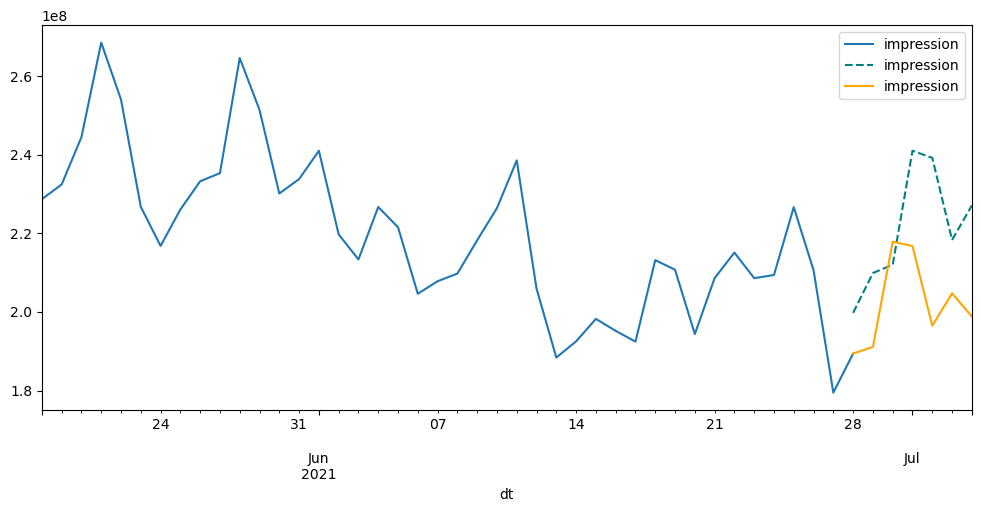

In [116]:
train_data = data.iloc[:42]    #train_data 
test_data = data.iloc[41:]    #test_data


#将预测结果写入到impression
pre = test_data.copy()
prediction = tsf(states_value, train_data_mean)[:,:,-1][0]
pre['impression'] = prediction


#绘图观察时间序列数据
train_data.plot(figsize = (12, 5), legend = True)
pre['impression'].plot(legend = True, color='teal',linestyle='--')
test_data['impression'].plot(legend = True, color='orange')
plt.show()

In [121]:
## 模型的评价
# 定义mape检验函数
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print('MAPE_model ：','%.2f' % mean_absolute_percentage_error(expectation, prediction),'%')

MAPE_model ： 10.87 %


In [49]:
encode_series = encoder_input_data[0:0+1,:,:] 
encode_series

array([[[ 0.04245261],
        [ 0.07381554],
        [ 0.08259913],
        [ 0.20000845],
        [ 0.14880361],
        [ 0.06037675],
        [ 0.07615566],
        [ 0.10654935],
        [ 0.01413798],
        [-0.01537514],
        [ 0.04533076],
        [ 0.02229089],
        [-0.05718353],
        [-0.04169155],
        [-0.03238016],
        [ 0.0072553 ],
        [ 0.04408063],
        [ 0.09628425],
        [-0.05070642],
        [-0.139799  ],
        [-0.11820858],
        [-0.08894099],
        [-0.10440347],
        [-0.11856381],
        [-0.0161703 ],
        [-0.02773107],
        [-0.10862965],
        [-0.03786035],
        [-0.00719608],
        [-0.03796672],
        [-0.03409197],
        [ 0.04512837],
        [-0.02837051]]])

In [50]:
states_value = model.predict(encode_series)

In [51]:
states_value

array([[-0.09992661, -0.04937298, -0.04195541,  0.08284862,  0.07957211,
        -0.01138155,  0.02642369]], dtype=float32)

In [52]:
tsf(states_value, train_data_mean)

array([[[1.99344361e+08],
        [2.09681020e+08],
        [2.11242126e+08],
        [2.39321785e+08],
        [2.38538927e+08],
        [2.17800358e+08],
        [2.26191976e+08]]])

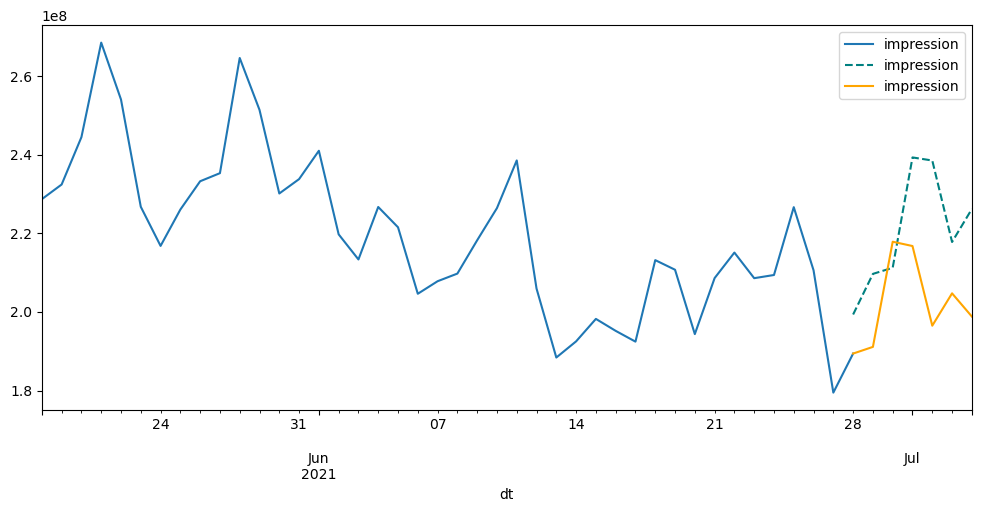

In [53]:
train_data = data.iloc[:42]    #train_data 
test_data = data.iloc[41:]    #test_data


#将预测结果写入到impression
pre = test_data.copy()
prediction = tsf(states_value, train_data_mean)[:,:,-1][0]
pre['impression'] = prediction


#绘图观察时间序列数据
train_data.plot(figsize = (12, 5), legend = True)
pre['impression'].plot(legend = True, color='teal',linestyle='--')
test_data['impression'].plot(legend = True, color='orange')
plt.show()

In [54]:
expectation = data.iloc[41:].values    #train_data 
expectation

array([[189400067],
       [191099608],
       [217866198],
       [216771541],
       [196494562],
       [204728949],
       [198829328]])

In [120]:
## 模型的评价
# 定义mape检验函数
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print('MAPE_model ：','%.2f' % mean_absolute_percentage_error(expectation, prediction),'%')

MAPE_model ： 10.87 %


## 滑动预测


In [ ]:
predicted = []
for i in range(predict_length):
    predict2 = model.predict(x_pp) #x_pp是预测输入序列
    predict = predict2.tolist()
    x_pp = x_pp[0][1:]
    x_pp.append(predict[0][0])
    predicted.append(predict[0][0])
    x_pp = [x_pp]

# LSTM + 细粒度预估

使用6.28号 的细粒度 作为“模板” 统计前41 天的同等细粒度的值，最后预估6.28 号的粒度值，这种预测的训练方法是将 “day” 作为lstm 的每个单元的输入，然后通过序列预测的特征，来预测最后一天的 细粒度的值。

In [2]:
!nvidia-smi

Wed Oct 20 07:43:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:02:00.0 Off |                    0 |
| N/A   36C    P0    50W / 250W |    533MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:03:00.0 Off |                    0 |
| N/A   27C    P8    10W / 250W |     10MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import numpy as np
import pandas as pd
import os
import sys
import inspect

from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import constraints
# from tensorflow.keras.utils import generic_utils
from tensorflow.keras import initializers
# from tensorflow.keras.legacy import interfaces
from tensorflow.keras.layers import Layer, RNN, LSTM
from tensorflow.keras import regularizers

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


## 数据集导入

In [5]:
# 读取 6-28号 一天的细粒度的数据
col_name = [
    "p_gender" 
    ,"age_level" 
    ,"businessman" 
    ,"passenger_os_type" 
    ,"city_id" 
    ,"res_id" 
    ,"slide_id" 
    ,"business_id" 
    ,"weekDay" 
    ,"dayOfyear" 
    ,"monthOfyear" 
    ,"request_num" 
    ,"request_num_2d" 
    ,"request_num_3d" 
    ,"request_num_4d" 
    ,"request_num_5d" 
    ,"request_num_6d" 
    ,"request_num_7d" 
    ,"request_num_7d_avg" 
    ,"last_week_reqeust_number" 
]

val_data_path="/nfs/volume-385-2/jinguopan/data/ad_request_data/ad_regression_data_v1/dt=20210628"
pre=pd.read_csv(os.path.join(val_data_path, os.listdir(val_data_path)[0]), sep="\t", header=None)

pre.columns=col_name

In [6]:
# 添加join 后的数据 并生成 三维的矩阵
datapath = "/nfs/volume-385-2/jinguopan/data/ad_request_data/ad_regression_data_v2/"
week_day=[
    "request_num"
    ,"request_num_2d" 
    ,"request_num_3d" 
    ,"request_num_4d" 
    ,"request_num_5d" 
    ,"request_num_6d" 
    ,"request_num_7d" 
    ,"request_num_7d_avg" 
    ,"last_week_reqeust_number" 
]
series_name=[
    "weekDay" 
    ,"dayOfyear" 
    ,"monthOfyear" 
    ,"request_num" 
    ,"request_num_2d" 
    ,"request_num_3d" 
    ,"request_num_4d" 
    ,"request_num_5d" 
    ,"request_num_6d" 
    ,"request_num_7d" 
    ,"request_num_7d_avg" 
    ,"last_week_reqeust_number" 
]


train_dates= sorted(os.listdir(datapath))
# save 3-d 
n_size = len(pre)
n_day = len(train_dates)
n_features = len(col_name)

# 3-d 
dataset = np.random.random((n_day, n_size, n_features))
for i, train_date in enumerate(train_dates):
    datadir=os.path.join(datapath, train_date);
    fileName=os.listdir(datadir)[0]
    df = pd.read_csv(os.path.join(datadir,fileName), sep="\t",header=None)
    df = df.replace("\\N", 0)
    df.columns=col_name
    df[series_name] = df[series_name].astype(float)
    
    # 平滑
    df[week_day] =  df[week_day].apply(lambda x:np.log1p(x))
    dataset[i] = df.values

In [7]:
## 将6.28 号的数据添加到 dataset中
pre = pre.replace("\\N", 0)
pre[series_name] = pre[series_name].astype(float)
# 平滑
pre[week_day] =  pre[week_day].apply(lambda x:np.log1p(x))

data = np.append(dataset, pre)
dim = dataset.shape  # 获取原矩阵的维数
data = data.reshape(dim[0]+1, dim[1], dim[2])

# reshape 
data = data.transpose(1,0,2)
# shape = (447975, 42)
target = data[:, :, 11]  # get request_num
# shape = (447975, 42, 19)
# data = np.delete(data, 11, axis=2)  # delect request_num

In [9]:
print(data.shape, target.shape)


"""
data: shape (47975, 42, 20)
      第一维度为细粒度的个数，第二维度为 days, 第三维度为 特征。

target: shape (447975, 42)
        第一维度为细粒度的维度，第二维度为days, 

"""

(447975, 42, 20) (447975, 42)


'\ndata: shape (47975, 42, 20)\n      第一维度为细粒度的个数，第二维度为 days, 第三维度为 特征。\n\ntarget: shape (447975, 42)\n        第一维度为细粒度的维度，第二维度为days, \n\n'

In [10]:
### 训练样本和预测样本
train_data = data[:, :-2, :] 
train_target = target[:, -2]

## 预测集
pre_data = data[:, 1:-1, :]
pre_target = target[:, -1]

In [28]:
### 测试归一化连续值
# Encode 稀疏特征
sparse_features = [
    "p_gender" 
    ,"age_level" 
    ,"businessman" 
    ,"passenger_os_type" 
    ,"city_id" 
    ,"res_id" 
    ,"slide_id" 
    ,"business_id" 
    ,"weekDay" 
    ,"dayOfyear" 
    ,"monthOfyear" 
]

for feat in sparse_features:
    le = LabelEncoder()
    pre1[feat] = le.fit_transform(pre1[feat])
    
# 稠密特征归一化
dense_features = [feat for feat in pre1.columns if feat not in sparse_features]
mms = MinMaxScaler(feature_range=(0, 1))
pre1[dense_features] = mms.fit_transform(pre1[dense_features])

## 数据集构造

有两种方式训练模型：<br>
【1】第一种参考 LSTM + series 作为输入， 类似 (1, 40, 1） 将粒度作为第一维，第二维是时间序列，第三维时每天的特征 <br>
1. 将(447975, 39, 19) 通过embedding 转化后得到 （447975, 39, 1）<br>
2. 训练集的label 为 （447975, 3, 1） <br>


【2】第二种输入 将20种不同的特征转化成 一个embedding后， 作为时间序列

### 定义模型结构【1】

In [12]:
def build_model():
    model = Sequential()
    layers = [19, 50, 100, 1]
    
    model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(layers[3]))
    model.add(Activation("linear"))  # 由于在进行线性回归操作，所以激活函数填 linear
 
    model.compile(loss="mae", optimizer=keras.optimizers.Adam(lr=0.0005), metrics=['mae', 'mape'])
    return model



# # 并定义网络结构 (两层)
# # 有给出输出输入的类型
# inputs = keras.Input(shape=(None, 1)) 

# # Add LSTM
# x = layers.LSTM(64, return_sequences=True)(inputs)
# x = layers.Dropout(0.2)(x)
# x = layers.LSTM(32, return_sequences=False)(x)
# x = layers.Dropout(0.2)(x)
# outputs = layers.Dense(7, activation='linear')(x)

# model_2 = keras.Model(inputs, outputs)
# model_2.summary()

In [24]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 50)          14000     
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 74,501
Trainable params: 74,501
Non-trainable params: 0
____________________________________________________

In [31]:
history = model.fit(train_data,
                    train_target,
#                     validation_data=(pre_data, pre_target),
                    epochs=100,
#                     batch_size=100,
                    steps_per_epoch=1000,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4345 - mae: 0.4345 - mape: 68729248.0000
Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4142 - mae: 0.4142 - mape: 45783256.0000
Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4251 - mae: 0.4251 - mape: 66815896.0000
Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4055 - mae: 0.4055 - mape: 44194312.0000
Epoch 5/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4279 - mae: 0.4279 - mape: 65223840.0000
Epoch 6/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4025 - mae: 0.4025 - mape: 49719284.0000
Epoch 7/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4158 - mae: 0.4158 - mape: 60814488.0000
Epoch 8/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3979 - mae: 0.3979 - mape: 51578776.0000
Epoch 9/100
1000/1000 [=================

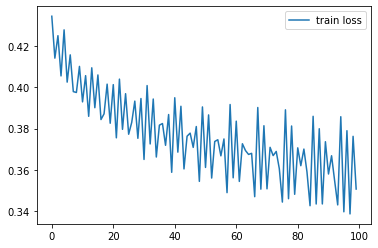

In [32]:
# 训练集和验证集的损失图
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [33]:
## 模型预测
states_value = model.predict(pre_data)
states_value

array([[2.2348948],
       [4.023001 ],
       [2.5768538],
       ...,
       [2.4729583],
       [4.7832417],
       [1.473598 ]], dtype=float32)

In [36]:
model_name = "./model_save/sfm_save.h5"
model.save(model_name)

In [7]:
# 导入模型
model_path = "./model_save/sfm_save.h5"
model = tf.keras.models.load_model(model_path)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 50)          14000     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 74,501
Trainable params: 74,501
Non-trainable params: 0
__________________________________________________

In [34]:
y_pred = np.expm1(states_value).reshape(1,-1)[0]
y_pred 

array([  8.345498 ,  54.868526 ,  12.155682 , ...,  10.857473 ,
       118.49108  ,   3.3649118], dtype=float32)

In [19]:
val_data_path="/nfs/volume-385-2/jinguopan/data/ad_request_data/ad_regression_data_v1/dt=20210628"
pre_dat=pd.read_csv(os.path.join(val_data_path, os.listdir(val_data_path)[0]), sep="\t", header=None)

pre_dat.columns=col_name
pre_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447975 entries, 0 to 447974
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p_gender                  447975 non-null  int64  
 1   age_level                 447975 non-null  int64  
 2   businessman               447975 non-null  int64  
 3   passenger_os_type         447975 non-null  int64  
 4   city_id                   447975 non-null  int64  
 5   res_id                    447975 non-null  int64  
 6   slide_id                  447975 non-null  int64  
 7   business_id               447975 non-null  int64  
 8   weekDay                   447975 non-null  float64
 9   dayOfyear                 447975 non-null  float64
 10  monthOfyear               447975 non-null  float64
 11  request_num               447975 non-null  float64
 12  request_num_2d            447975 non-null  object 
 13  request_num_3d            447975 non-null  o

In [20]:
### 预测 6.28
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def wmape(y_true, y_pre):
    return np.sum(y_true/np.sum(y_true)*(np.abs((y_pre-y_true)/y_true)))*100


In [35]:
print('The mape of prediction is:', mape(pre_dat['request_num'], y_pred))
print('The wmape of prediction is:', wmape(pre_dat['request_num'], y_pred))

The mape of prediction is: 55.43365904724137
The wmape of prediction is: 33.77864949103262


In [37]:
import pandas as pd

pre_dat['pre_request_num'] = y_pred

### 定义模型结构【2】

这里定义模型结构和之前一样，不同的是19个特征："p_gender" ,"age_level" ,"businessman" ,"passenger_os_type" ,"city_id" ,"res_id" ,"slide_id" ,"business_id" ,"weekDay" ,"dayOfyear" ,"monthOfyear" ,"request_num" ,"request_num_2d","request_num_3d" ,"request_num_4d" ,"request_num_5d" ,"request_num_6d" ,"request_num_7d" ,"request_num_7d_avg" ,"last_week_reqeust_number"。 分成连续值和标签值分别训练。


这里训练的输入是 一条一条样本作为输入，例如 ”p_gender“ 的输入为一条样本，并且 ”p_gender“ 代表这一列样本。

In [14]:
## 统计出 6.28 号 各个细粒度的值
ls = pre[col_name].apply(lambda x : x.unique())
ls

p_gender                                                              [-1, 1]
age_level                                                  [1, 2, 3, 4, 5, 6]
businessman                                                            [0, 1]
passenger_os_type                                                    [1, 101]
city_id                     [-1, 0, 1, 10, 100, 101, 102, 103, 104, 105, 1...
res_id                      [213, 219, 195, 197, 199, 201, 235, 38, 383, 4...
slide_id                                                               [1, 2]
business_id                 [260, 307, 309, 363, 372, 666, 258, 995, 994, ...
weekDay                                                                 [1.0]
dayOfyear                                                              [28.0]
monthOfyear                                                             [6.0]
request_num                 [2.3978952727983707, 3.912023005428146, 2.8903...
request_num_2d              [2.995732273553991, 4.45434729625350

使用tf.feature_columns处理，输入的样本其实是一条向量，例如：“age_level” 该特征 的样本输入为一条向量，如果输入为矩阵的形式，

In [14]:
import tensorflow as tf
import  tensorflow.keras.backend as k
feature_columns=[ 
    'p_gender','age_level','businessman','passenger_os_type','city_id','res_id','slide_id','business_id',
    'weekDay','dayOfyear','monthOfyear','request_num_2d','request_num_3d','request_num_4d',
    'request_num_5d','request_num_6d','request_num_7d','request_num_7d_avg','last_week_reqeust_number' ]
# string 类型的 字段
category_columns = ['p_gender','age_level','businessman','passenger_os_type','city_id','res_id','slide_id','business_id']
def generate_inputs():
    inputs={};
    for column in feature_columns:
        if column in category_columns:
            inputs[column]=tf.keras.layers.Input(shape=(),name=column,dtype=tf.int64);
        else:
            inputs[column] = tf.keras.layers.Input(shape=(), name=column, dtype=tf.float32);
        pass

    return inputs;

def get_input(config):
    """
    解析类别特征有：
        1. categorical_column_with_identity	       生成的子类：CategoricalColumn
        2. categorical_column_with_vocabulary_list      生成的子类：CategoricalColumn，存有vocabulary_list
        3. categorical_column_with_vocabulary_file      生成的子类：CategoricalColumn，存有vocabulary_file
        4. categorical_column_with_hash_bucket      生成的子类：HashedCategoricalColumn
    数值类型
        1. tf.feature_column.numeric_column    连续值
        2. tf.feature_column.bucketized_column    分箱列
        
    """
    p_gender_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("p_gender", vocabulary_list=[-1, 1],default_value=-99999)
    age_level_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("age_level", vocabulary_list=[1, 2, 3, 4, 5, 6],default_value=-99999)
    businessman_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("businessman", vocabulary_list=[0, 1],default_value=-99999)
    passenger_os_type_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("passenger_os_type",vocabulary_list=[1, 101],default_value=-99999)
#     city_id_hash_feature_column=tf.feature_column.categorical_column_with_hash_bucket("city_id",hash_bucket_size=372)
    city_id_hash_feature_column=tf.feature_column.categorical_column_with_vocabulary_list("city_id", vocabulary_list=config['city_id'],default_value=-99999)
    res_id_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("res_id",vocabulary_list=[213, 215, 219, 67, 195, 197, 199, 201, 235, 383, 391, 405, 456, 457, 50, 526, 63, 71, 10079, 10080, 10082, 10083, 10084, 10085, 18, 24, 245, 259, 38, 448, 36, 449, 450, 395, 451, 452, 453, 454, 99],default_value=-99999)
    slide_id_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("slide_id",vocabulary_list=[1,2],default_value=-99999)
    
    business_id_category_feature_colum=tf.feature_column.categorical_column_with_vocabulary_list("business_id",vocabulary_list=[260, 258, 307, 309, 362, 363, 372, 666, 995, 994, 997, 256, 1002, 276, 1200, 386, 373, 310, 1001],default_value=-99999)
    weekDay_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("weekDay"), boundaries=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
    dayOfyear_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("dayOfyear"), boundaries=[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 29.0, 31.0])
    monthOfyear_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("monthOfyear"), boundaries=[5.0, 6.0])
    request_num_2d_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_2d"), boundaries=[1.0, 2.0, 3.0, 4.0, 6.0, 9.0, 12.0, 16.0, 21.0, 27.0, 37.0, 50.0, 68.0, 95.0, 136.0, 201.0, 310.0, 516.0, 988.0, 2569.999755859375, 1217583.0])
    request_num_3d_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_3d"), boundaries=[1.0, 2.0, 4.0, 6.0, 8.0, 12.0, 16.0, 21.0, 28.0, 38.0, 51.0, 69.0, 95.0, 133.0, 191.0, 284.0, 440.0, 736.0, 1416.0, 3709.0, 1756145.0])
    request_num_4d_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_4d"), boundaries=[1.0, 2.0, 5.0, 7.0, 11.0, 15.0, 20.0, 27.0, 36.0, 48.0, 64.0, 88.0, 121.0, 170.0, 244.0, 364.0, 566.0, 948.0, 1830.0, 4818.0, 2218971.0])
    request_num_5d_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_5d"), boundaries=[1.0, 3.0, 5.0, 8.0, 12.0, 17.0, 24.0, 32.0, 43.0, 57.0, 77.0, 106.0, 146.0, 205.0, 295.0, 441.0, 688.0, 1154.0, 2232.0, 5894.0, 2673456.0])
    request_num_6d_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_6d"), boundaries=[1.0, 3.0, 6.0, 10.0, 14.0, 20.0, 27.0, 37.0, 49.0, 66.0, 90.0, 123.0, 170.0, 239.0, 344.0, 515.0, 804.0, 1351.0001220703125, 2621.0, 6938.0, 3107520.0])
    request_num_7d_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_7d"), boundaries=[1.0, 3.0, 7.0, 11.0, 16.0, 23.0, 31.0, 42.0, 56.0, 75.0, 102.0, 139.0, 192.0, 271.0, 391.0, 586.0, 916.0, 1542.0, 2996.0, 7952.0, 3488908.0])
    request_num_7d_avg_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("request_num_7d_avg"), boundaries=[1.0, 1.3333330154418945, 2.0, 2.571428060531616, 3.3333330154418945, 4.285714149475098, 5.5714287757873535, 7.142857074737549, 9.285714149475098, 12.285714149475098, 16.428571701049805, 22.14285659790039, 30.428571701049805, 42.57143020629883, 61.0, 90.57142639160156, 140.57142639160156, 235.5, 454.5714416503906, 1197.2857666015625, 498415.4375])
    last_week_reqeust_number_bucketized_feature_column=tf.feature_column.bucketized_column(tf.feature_column.numeric_column("last_week_reqeust_number"), boundaries=[1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 10.0, 13.0, 17.0, 22.0, 30.0, 40.0, 56.0, 79.0, 115.0, 176.0, 291.0, 552.0, 1419.0001220703125, 670872.0])
    
    # 定义 categorical 和 dense 类别 特征
    category_feature_column_names= [p_gender_category_feature_colum, age_level_category_feature_colum, businessman_category_feature_colum, passenger_os_type_category_feature_colum, res_id_category_feature_colum, slide_id_category_feature_colum, business_id_category_feature_colum]
    hash_feature_column_names= [city_id_hash_feature_column]
    number_bucket_feature_column_names= [weekDay_bucketized_feature_column, dayOfyear_bucketized_feature_column, monthOfyear_bucketized_feature_column, request_num_2d_bucketized_feature_column, request_num_3d_bucketized_feature_column, request_num_4d_bucketized_feature_column, request_num_5d_bucketized_feature_column, request_num_6d_bucketized_feature_column, request_num_7d_bucketized_feature_column, request_num_7d_avg_bucketized_feature_column, last_week_reqeust_number_bucketized_feature_column]
    
    feature_column_names = [];
    feature_column_names += category_feature_column_names;
    feature_column_names += hash_feature_column_names;
    inputs = generate_inputs();
    input_embeddings_list1 = [tf.keras.layers.DenseFeatures([tf.feature_column.embedding_column(feature_column, 32)])({
        feature_column.key: inputs[feature_column.key]
    })
        for feature_column in feature_column_names]
    input_embeddings_list2 = [tf.keras.layers.DenseFeatures([tf.feature_column.embedding_column(feature_column, 32)])({
        feature_column.source_column.key: inputs[feature_column.source_column.key]}
        )
        for feature_column in number_bucket_feature_column_names]
    
    input_embeddings = input_embeddings_list1 + input_embeddings_list2;
    input_embeddings = [k.expand_dims(input_embedding, axis=1) for input_embedding in input_embeddings]
    input_embeddings = k.concatenate(input_embeddings, axis=1)
    input_embeddings = tf.keras.layers.Flatten()(input_embeddings)
    return inputs, input_embeddings; 

In [15]:
inputs, input_embeddings = get_input(ls)
inputs, input_embeddings

({'p_gender': <tf.Tensor 'p_gender:0' shape=(None,) dtype=int64>,
  'age_level': <tf.Tensor 'age_level:0' shape=(None,) dtype=int64>,
  'businessman': <tf.Tensor 'businessman:0' shape=(None,) dtype=int64>,
  'passenger_os_type': <tf.Tensor 'passenger_os_type:0' shape=(None,) dtype=int64>,
  'city_id': <tf.Tensor 'city_id:0' shape=(None,) dtype=int64>,
  'res_id': <tf.Tensor 'res_id:0' shape=(None,) dtype=int64>,
  'slide_id': <tf.Tensor 'slide_id:0' shape=(None,) dtype=int64>,
  'business_id': <tf.Tensor 'business_id:0' shape=(None,) dtype=int64>,
  'weekDay': <tf.Tensor 'weekDay:0' shape=(None,) dtype=float32>,
  'dayOfyear': <tf.Tensor 'dayOfyear:0' shape=(None,) dtype=float32>,
  'monthOfyear': <tf.Tensor 'monthOfyear:0' shape=(None,) dtype=float32>,
  'request_num_2d': <tf.Tensor 'request_num_2d:0' shape=(None,) dtype=float32>,
  'request_num_3d': <tf.Tensor 'request_num_3d:0' shape=(None,) dtype=float32>,
  'request_num_4d': <tf.Tensor 'request_num_4d:0' shape=(None,) dtype=float3

In [16]:
### 定义LSTM 网络层
# hidden_units = [128, 64, 32]

class lstm(Layer):
    def __init__(self, activation='relu', dropout=0.1):
        super(lstm, self).__init__()
        self.lstm_input = LSTM(units = 256, activation=activation, return_sequences=True)
        self.lstm_network = LSTM(units=64, activation=activation, return_sequences= False)
        self.dropout = Dropout(dropout)
        self.dense_final = Dense(1, activation='linear')
    
    def call(self, inputs, **kwargs):
        x = self.lstm_input(inputs)
        x = self.lstm_network(x)
        x = self.dense_final(x)
        return x

In [122]:
# input data 
train_list = {
#     "p_gender" : data[:,:,0]
    "age_level" : data[:,:,1]
    ,"businessman" : data[:,:,2]
    ,"passenger_os_type" : data[:,:,3]
#     ,"city_id" : data[:,:,4]
    ,"res_id" : data[:,:,5]
    ,"slide_id" : data[:,:,6]
    ,"business_id" : data[:,:,7]
    ,"weekDay" : data[:,:,8]
    ,"dayOfyear" : data[:,:,9]
    ,"monthOfyear" : data[:,:,10]
    ,"request_num_2d" : data[:,:,12]
    ,"request_num_3d" : data[:,:,13]
    ,"request_num_4d" : data[:,:,14]
    ,"request_num_5d" : data[:,:,15]
    ,"request_num_6d" : data[:,:,16]
    ,"request_num_7d" : data[:,:,17]
    ,"request_num_7d_avg" : data[:,:,18]
    ,"last_week_reqeust_number" : data[:,:,19]
}


target_list = {
    "request_num" : data[:,:,11][:, -2]
}


In [28]:
data[:,:,0][:,[0]]

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [ 1.],
       [ 1.],
       [ 1.]])

In [30]:

output = lstm()(K.expand_dims(input_embeddings, axis=1))

model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p_gender (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
age_level (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
businessman (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_os_type (InputLayer)  [(None,)]            0                                            
_______________________________________________________________________________________

In [36]:
tf.keras.utils.plot_model(model, to_file='model3.png', show_shapes=False, show_layer_names=True,rankdir='TB', dpi=900, expand_nested=True)


In [38]:

# -- compile --- 
model.compile(loss="mae", 
              optimizer=keras.optimizers.Adam(lr=0.0005), 
              metrics=['mae', 'mape'])

# -- fit --- 



In [39]:
epochs = 100

model.fit(
    train_list,
    target_list['request_num'], 
    epochs=epochs,
    batch_size=100,
    verbose=1,
    shuffle=False
)

Epoch 1/100


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[25,0] = 2 is not in [0, 2)
	 [[node functional_4/embedding_126/embedding_lookup (defined at <ipython-input-39-16667512e434>:9) ]]
	 [[GroupCrossDeviceControlEdges_0/Adam/Adam/Const/_341]]
  (1) Invalid argument:  indices[25,0] = 2 is not in [0, 2)
	 [[node functional_4/embedding_126/embedding_lookup (defined at <ipython-input-39-16667512e434>:9) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10075]

Errors may have originated from an input operation.
Input Source operations connected to node functional_4/embedding_126/embedding_lookup:
 functional_4/embedding_126/embedding_lookup/7856 (defined at /home/luban/miniconda3/envs/tf23/lib/python3.7/contextlib.py:112)

Input Source operations connected to node functional_4/embedding_126/embedding_lookup:
 functional_4/embedding_126/embedding_lookup/7856 (defined at /home/luban/miniconda3/envs/tf23/lib/python3.7/contextlib.py:112)

Function call stack:
train_function -> train_function


### 定义模型结构【3】

这里还是分成 dense_feature 和 spare_feature 一起作为 训练样本作为输入，他们通过不同的输入进行embedding。

In [42]:
data[:,:,0].shape

(447975, 42)

In [13]:
# input data 
def define_dataset(data, label):
    train_list = {
    #     "p_gender" : data[:,:,0]  # shape: (447975, 42)
        "age_level" : data[:,:,1]
        ,"businessman" : data[:,:,2]
        ,"passenger_os_type" : data[:,:,3]
    #     ,"city_id" : data[:,:,4]
        ,"res_id" : data[:,:,5]
        ,"slide_id" : data[:,:,6]
        ,"business_id" : data[:,:,7]
        ,"weekDay" : data[:,:,8]
        ,"dayOfyear" : data[:,:,9]
        ,"monthOfyear" : data[:,:,10]
        ,"request_num_2d" : data[:,:,12]
        ,"request_num_3d" : data[:,:,13]
        ,"request_num_4d" : data[:,:,14]
        ,"request_num_5d" : data[:,:,15]
        ,"request_num_6d" : data[:,:,16]
        ,"request_num_7d" : data[:,:,17]
        ,"request_num_7d_avg" : data[:,:,18]
        ,"last_week_reqeust_number" : data[:,:,19]
    }
    
    if label == 'train':

        target_list = {
            "request_num" : data[:,:,11][:, -2]
        }
    else:
        target_list = {
            "request_num" : data[:,:,11][:, -1]
        }
    return train_list, target_list


### 训练样本和预测样本
train_list, target_list = define_dataset(train_data, 'train')
pre_list, pre_target_list = define_dataset(pre_data, 'pre')


In [14]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, LSTM, Dropout, Dense



def get_input(config, embedding_dim=16, output_dim=1):
    """
    实现 网络结构定义
    :return: inputs, outputs
    """
    sparseFeature = keras.Input(shape=(), name='sparse')
    denseFeature = keras.Input(shape=(), name='dense')

    # input
    inputs  = {}
    embed = []
    
    series_name=[
    "request_num_2d" 
    ,"request_num_3d" 
    ,"request_num_4d" 
    ,"request_num_5d" 
    ,"request_num_6d" 
    ,"request_num_7d" 
    ,"request_num_7d_avg" 
    ,"last_week_reqeust_number"]
    
    
    for column in config:
        # Variable-length sequence of ints
        inputs[column] = keras.Input(
            shape=(None,), name=column, dtype=tf.float64
        )

        # sparse_embedding and dense_embedding
        if column not in series_name:
            inputs_dim = int(np.max(config[column])) + 1
            embed_column = keras.layers.Embedding(inputs_dim, embedding_dim)(inputs[column])
            # 将这个层经过一层lstm进行降维 打平成一维
            # embed_column = LSTM(32)(embed_column)
            embed.append(embed_column)

        else:
            embed.append(K.expand_dims(inputs[column], axis=-1))

    outputs = keras.layers.concatenate(embed)
    return inputs, outputs




class lstm(Layer):
    def __init__(self, activation='relu', dropout=0.1):
        super(lstm, self).__init__()
        self.lstm_input = LSTM(units=256, activation=activation, return_sequences=True)
        self.lstm_network = LSTM(units=64, activation=activation, return_sequences=False)
        self.dropout = Dropout(dropout)
        self.dense_final = Dense(1, activation='linear')

    def call(self, inputs, **kwargs):
        x = self.lstm_input(inputs)
        x = self.lstm_network(x)
        x = self.dense_final(x)
        return x

In [15]:
inputs, outputs_embedding = get_input(train_list)
output = lstm()(outputs_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [16]:
inputs

{'age_level': <tf.Tensor 'age_level:0' shape=(None, None) dtype=float64>,
 'businessman': <tf.Tensor 'businessman:0' shape=(None, None) dtype=float64>,
 'passenger_os_type': <tf.Tensor 'passenger_os_type:0' shape=(None, None) dtype=float64>,
 'res_id': <tf.Tensor 'res_id:0' shape=(None, None) dtype=float64>,
 'slide_id': <tf.Tensor 'slide_id:0' shape=(None, None) dtype=float64>,
 'business_id': <tf.Tensor 'business_id:0' shape=(None, None) dtype=float64>,
 'weekDay': <tf.Tensor 'weekDay:0' shape=(None, None) dtype=float64>,
 'dayOfyear': <tf.Tensor 'dayOfyear:0' shape=(None, None) dtype=float64>,
 'monthOfyear': <tf.Tensor 'monthOfyear:0' shape=(None, None) dtype=float64>,
 'request_num_2d': <tf.Tensor 'request_num_2d:0' shape=(None, None) dtype=float64>,
 'request_num_3d': <tf.Tensor 'request_num_3d:0' shape=(None, None) dtype=float64>,
 'request_num_4d': <tf.Tensor 'request_num_4d:0' shape=(None, None) dtype=float64>,
 'request_num_5d': <tf.Tensor 'request_num_5d:0' shape=(None, None

In [17]:
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age_level (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
businessman (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
passenger_os_type (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
res_id (InputLayer)             [(None, None)]       0                                            
_______________________________________________________________________________________

In [18]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=900, expand_nested=True)


In [19]:

# -- compile --- 
model.compile(loss="mae", 
              optimizer=keras.optimizers.Adam(lr=0.0005), 
              metrics=['mae', 'mape'])

# -- fit --- 


In [33]:
epochs = 100

history = model.fit(
    train_list,
    target_list['request_num'], 
#     validation_data=(pre_list, pre_target_list['request_num']),
    epochs=epochs,
    batch_size=100,
    verbose=1,
    steps_per_epoch=20,
    shuffle=False
)


Epoch 1/100
20/20 [==============================] - 2s 94ms/step - loss: 0.2198 - mae: 0.2198 - mape: 5972124.5000
Epoch 2/100
20/20 [==============================] - 2s 97ms/step - loss: 0.2032 - mae: 0.2032 - mape: 7976537.5000
Epoch 3/100
20/20 [==============================] - 2s 91ms/step - loss: 0.1891 - mae: 0.1891 - mape: 7340273.5000
Epoch 4/100
20/20 [==============================] - 2s 94ms/step - loss: 0.2031 - mae: 0.2031 - mape: 10749684.0000
Epoch 5/100
20/20 [==============================] - 2s 95ms/step - loss: 0.2001 - mae: 0.2001 - mape: 10840337.0000
Epoch 6/100
20/20 [==============================] - 2s 95ms/step - loss: 0.1938 - mae: 0.1938 - mape: 11309239.0000
Epoch 7/100
20/20 [==============================] - 2s 94ms/step - loss: 0.1838 - mae: 0.1838 - mape: 12467388.0000
Epoch 8/100
20/20 [==============================] - 2s 92ms/step - loss: 0.1834 - mae: 0.1834 - mape: 9206084.0000
Epoch 9/100
20/20 [==============================] - 2s 97ms/step - 

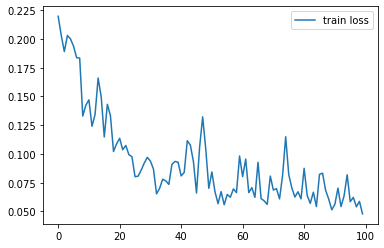

In [34]:
# 训练集和验证集的损失图
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [35]:
## 模型预测
states_value = model.predict(pre_list)
states_value

array([[2.596728 ],
       [4.0295424],
       [2.7857978],
       ...,
       [2.2194781],
       [5.6775136],
       [1.8753337]], dtype=float32)

In [ ]:
model_name = "./model_save/lstm_save.h5"
model.save(model_name)

In [7]:
# # 导入模型
# model_path = "./model_save/sfm_save.h5"
# model = tf.keras.models.load_model(model_path)

# model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 50)          14000     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 74,501
Trainable params: 74,501
Non-trainable params: 0
__________________________________________________

In [37]:
y_pred = np.expm1(states_value).reshape(1,-1)[0]
y_pred 

array([ 12.419758,  55.235176,  15.212748, ...,   8.202527, 291.22195 ,
         5.522995], dtype=float32)

In [38]:
val_data_path="/nfs/volume-385-2/jinguopan/data/ad_request_data/ad_regression_data_v1/dt=20210628"
pre_dat=pd.read_csv(os.path.join(val_data_path, os.listdir(val_data_path)[0]), sep="\t", header=None)

pre_dat.columns=col_name
pre_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447975 entries, 0 to 447974
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p_gender                  447975 non-null  int64  
 1   age_level                 447975 non-null  int64  
 2   businessman               447975 non-null  int64  
 3   passenger_os_type         447975 non-null  int64  
 4   city_id                   447975 non-null  int64  
 5   res_id                    447975 non-null  int64  
 6   slide_id                  447975 non-null  int64  
 7   business_id               447975 non-null  int64  
 8   weekDay                   447975 non-null  float64
 9   dayOfyear                 447975 non-null  float64
 10  monthOfyear               447975 non-null  float64
 11  request_num               447975 non-null  float64
 12  request_num_2d            447975 non-null  object 
 13  request_num_3d            447975 non-null  o

In [39]:
### 预测 6.28
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def wmape(y_true, y_pre):
    return np.sum(y_true/np.sum(y_true)*(np.abs((y_pre-y_true)/y_true)))*100


In [40]:
print('The mape of prediction is:', mape(pre_dat['request_num'], y_pred))
print('The wmape of prediction is:', wmape(pre_dat['request_num'], y_pred))

The mape of prediction is: 63.9312597342257
The wmape of prediction is: 68.81168525689866


### 定义模型结构【4】



数据运用的模型中，输入的样本应该是 没有时间 作为特征的输入， 输入的维度为 （447975, 7）， 输入的target 为 （447975，1）<br>

所以，需要将输入 的三维降 到二维数据 进行concat 后一起放入到模型中训练

In [82]:
## 对request_num 进行滑窗m天处理 用来预测后n天
def spilt_data(dat, m_in, n_out):
    n_row, n_col = dat.shape[0], dat.shape[1]
    res = list()
    
    # 
    for i in range(0, n_col-(m_in+n_out) + 1):
        res.append(dat[:, i:i+(m_in+n_out)])
        
    return res
    

In [83]:
res = spilt_data(target, 7, 1)

In [84]:
# 训练集
train = np.array(res[:-1])  # (34, 447975, 8)
train_dat, train_target = train[:, :, :-1], train[:, :, [-1]]
# 预测集 
pre = res[-1]  # （447975, 8）
pre_dat, pre_target = pre[:, :-1], pre[:, [-1]]

In [52]:
train_dat = train_dat.reshape((-1, 7))
train_target = train_target.reshape((-1, 1))


def transform(values):
    return values.reshape(values.shape[0], values.shape[1], 1)

train_x, train_y = transform(train_dat), train_target
test_x, test_y  = transform(pre_dat), pre_target


print(f"Training data shape: {train_x.shape}")
print(f"Training data shape: {train_y.shape}")
print(f"Validation data shape: {test_x.shape}")
print(f"Validation data shape: {test_y.shape}")

Training data shape: (15231150, 7, 1)
Training data shape: (15231150, 1)
Validation data shape: (447975, 7, 1)
Validation data shape: (447975, 1)


In [59]:
### 定义模型
# # 并定义网络结构
# model_1 = keras.Sequential()
# model_1.add(keras.layers.LSTM(64, input_shape=(train_x.shape[1], train_x.shape[2])))
# model_1.add(keras.layers.Dense(n_out))
# model_1.add(keras.layers.Activation("linear"))
# model_1.summary()


# 并定义网络结构
inputs = keras.Input(shape=(train_x.shape[1], train_x.shape[2])) 
# Add LSTM
x = LSTM(64)(inputs)

outputs = Dense(1, activation="linear")(x)
model_1 = keras.Model(inputs, outputs)
model_1.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [62]:
model = model_1
model.compile(loss="mae", optimizer="adam")

history = model.fit(train_x,
                    train_y,
#                     validation_data=(test_x, test_y),
                    epochs=100,
                    batch_size=100,
                    steps_per_epoch=1000,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3421
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2981
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3472
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2865
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3437
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2954
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3331
Epoch 8/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3018
Epoch 9/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3020
Epoch 10/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3234
Epoch 11/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2851
Epoch 12/100
1000/1000 [==============================] - 3s 3ms/step - lo

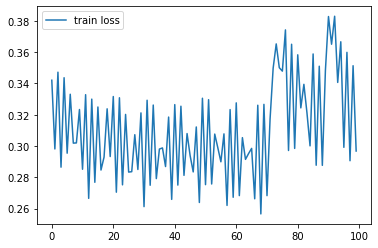

In [63]:
# 训练集和验证集的损失图
plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [64]:
predict_dat = model.predict(test_x)

In [77]:
y_pred = np.expm1(predict_dat).reshape(1,-1)[0]
test_y = np.expm1(test_y).reshape(1,-1)[0]

In [78]:
### 预测 6.28
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def wmape(y_true, y_pre):
    return np.sum(y_true/np.sum(y_true)*(np.abs((y_pre-y_true)/y_true)))*100


In [83]:
print('The mape of prediction is:', mape(test_y, y_pred))
print('The wmape of prediction is:', wmape(test_y, y_pred))

The mape of prediction is: 41.201596453533355
The wmape of prediction is: 12.253547380534753


### 定义模型结构【5】

In [67]:
## 对所有特征都进行 进行滑窗m天处理 用来预测后n天
def spilt_data(dat, m_in, n_out):
    n_row, n_col = dat.shape[0], dat.shape[1]
    res = list()

    # 得到特征的list表
    for i in range(0, n_col - (m_in + n_out) + 1):
        res.append(dat[:, i:i + (m_in + n_out)])

    #
    train = np.array(res[:-1])  # (34, 447975, 8)
    pre = np.array(res[-1])  # (447975, 8)

    return train, pre



# input data
def define_dataset(data, m_in=7, n_out=1):
    train_list = {
#         "p_gender" : data[:,:, 0] # shape: (447975, 42)
#         ,"age_level": data[:, :, 1]
#         , "businessman": data[:, :, 2]
#         , "passenger_os_type": data[:, :, 3]
#         ,"city_id" : data[:,:,4]
#         , "res_id": data[:, :, 5]
#         , "slide_id": data[:, :, 6]
#         , "business_id": data[:, :, 7]
#         , "weekDay": data[:, :, 8]
#         , "dayOfyear": data[:, :, 9]
#         , "monthOfyear": data[:, :, 10]
        "request_num" : data[:, :, 11]
        , "request_num_2d": data[:, :, 12]
        , "request_num_3d": data[:, :, 13]
        , "request_num_4d": data[:, :, 14]
        , "request_num_5d": data[:, :, 15]
        , "request_num_6d": data[:, :, 16]
        , "request_num_7d": data[:, :, 17]
        , "request_num_7d_avg": data[:, :, 18]
        , "last_week_reqeust_number": data[:, :, 19]
    }
    # 预测集合
    pre_list = train_list.copy()

    # 重新构造 train_list
    for column in train_list:

        if column == 'request_num':
            train, pre = spilt_data(train_list[column], m_in, n_out)

            # 训练集 不需要读取最后一列
            train_dat, train_target = train[:, :, :-1], train[:, :, [-1]]

            # reshape
            train_list[column] = train_dat.reshape((-1, m_in))  # shape: (15231150, 1)
            target_list = train_target.reshape((-1, n_out))
            
            # predict data
            pre_list[column] = pre[:, :-1]
            pre_target = pre[:, [-1]] 
            
        else:
            train, pre = spilt_data(train_list[column], m_in, n_out)
            # 训练集 不需要读取最后一列
            train_dat = train[:, :, :-1]

            # reshape
            train_list[column] = train_dat.reshape((-1, m_in))  # shape: (15231150, 1)

            # predict 
            pre_list[column] = pre[:, :-1]

    return train_list, target_list, pre_list, pre_target


In [68]:
train_list, target_list, pre_list, pre_target = define_dataset(data)

In [69]:
print(train_list['request_num'].shape, target_list.shape)
print(pre_list['request_num'].shape, pre_target.shape)


(15231150, 7) (15231150, 1)
(447975, 7) (447975, 1)


In [107]:
def get_input(config):
    """
    实现 网络结构定义
    :return: inputs, outputs
    """

    # input
    inputs = {}
    embed = []

    for column in config:
        # Variable-length sequence of ints
        inputs[column] = keras.Input(
            shape=(None, ), name=column, dtype=tf.float64
        )

        embed.append(K.expand_dims(inputs[column], axis=-1))

    outputs = keras.layers.concatenate(embed)
    return inputs, outputs



class lstm(Layer):
    def __init__(self, activation='relu', dropout=0.1):
        super(lstm, self).__init__()
        self.lstm_input = LSTM(units=256, activation=activation, return_sequences=True)
        self.lstm_network = LSTM(units=64, activation=activation, return_sequences=False)
        self.dropout = Dropout(dropout)
        self.dense_final = Dense(1, activation='linear')

    def call(self, inputs, **kwargs):
        x = self.lstm_input(inputs)
        x = self.lstm_network(x)
        x = self.dense_final(x)
        return x


In [108]:
inputs, outputs_embedding = get_input(train_list)
output = lstm()(outputs_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [111]:
inputs, outputs_embedding

({'p_gender': <tf.Tensor 'p_gender_7:0' shape=(None, None) dtype=float64>,
  'age_level': <tf.Tensor 'age_level_7:0' shape=(None, None) dtype=float64>,
  'businessman': <tf.Tensor 'businessman_7:0' shape=(None, None) dtype=float64>,
  'passenger_os_type': <tf.Tensor 'passenger_os_type_7:0' shape=(None, None) dtype=float64>,
  'city_id': <tf.Tensor 'city_id_7:0' shape=(None, None) dtype=float64>,
  'res_id': <tf.Tensor 'res_id_7:0' shape=(None, None) dtype=float64>,
  'slide_id': <tf.Tensor 'slide_id_7:0' shape=(None, None) dtype=float64>,
  'business_id': <tf.Tensor 'business_id_7:0' shape=(None, None) dtype=float64>,
  'weekDay': <tf.Tensor 'weekDay_7:0' shape=(None, None) dtype=float64>,
  'dayOfyear': <tf.Tensor 'dayOfyear_7:0' shape=(None, None) dtype=float64>,
  'monthOfyear': <tf.Tensor 'monthOfyear_7:0' shape=(None, None) dtype=float64>,
  'request_num': <tf.Tensor 'request_num_8:0' shape=(None, None) dtype=float64>,
  'request_num_2d': <tf.Tensor 'request_num_2d_8:0' shape=(Non

In [73]:
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
request_num (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
request_num_2d (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
request_num_3d (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
request_num_4d (InputLayer)     [(None, None)]       0                                            
_______________________________________________________________________________________

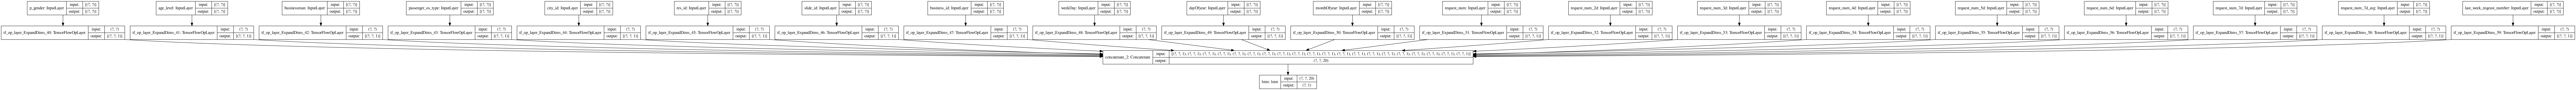

In [23]:
tf.keras.utils.plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=900, expand_nested=True)


In [74]:

# -- compile --- 
model.compile(loss="mae", 
              optimizer=keras.optimizers.Adam(lr=0.0005), 
              metrics=['mae', 'mape'])

# -- fit --- 


In [75]:
epochs = 100

history = model.fit(
    train_list, 
    target_list, 
#     validation_data=(pre_list, pre_target_list['request_num']),
    epochs=epochs,
    batch_size=100,
    verbose=1,
    steps_per_epoch=100,
    shuffle=False
)


Epoch 1/100
100/100 [==============================] - 2s 20ms/step - loss: 0.5516 - mae: 0.5516 - mape: 72147160.0000
Epoch 2/100
100/100 [==============================] - 2s 20ms/step - loss: 0.4444 - mae: 0.4444 - mape: 74633624.0000
Epoch 3/100
100/100 [==============================] - 2s 20ms/step - loss: 0.4563 - mae: 0.4563 - mape: 64626792.0000
Epoch 4/100
100/100 [==============================] - 2s 22ms/step - loss: 0.4512 - mae: 0.4512 - mape: 71200536.0000
Epoch 5/100
100/100 [==============================] - 2s 20ms/step - loss: 0.3959 - mae: 0.3959 - mape: 72802320.0000
Epoch 6/100
100/100 [==============================] - 2s 21ms/step - loss: 0.3446 - mae: 0.3446 - mape: 58782280.0000
Epoch 7/100
100/100 [==============================] - 2s 20ms/step - loss: 0.3500 - mae: 0.3500 - mape: 58901216.0000
Epoch 8/100
100/100 [==============================] - 2s 21ms/step - loss: 0.3744 - mae: 0.3744 - mape: 62479492.0000
Epoch 9/100
100/100 [===========================

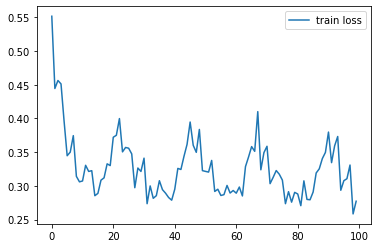

In [76]:
# 训练集和验证集的损失图
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [77]:
## 模型预测
states_value = model.predict(pre_list)
states_value

array([[2.1320214],
       [3.707849 ],
       [2.5984998],
       ...,
       [2.3494427],
       [5.077718 ],
       [1.8131235]], dtype=float32)

In [78]:
y_pred = np.expm1(states_value).reshape(1,-1)[0]

test_y = np.expm1(pre_target).reshape(1,-1)[0]

In [79]:
### 预测 6.28
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def wmape(y_true, y_pre):
    return np.sum(y_true/np.sum(y_true)*(np.abs((y_pre-y_true)/y_true)))*100


In [66]:
# 将label 特征的数据和 连续的数据一起放入模型做训练
print('The mape of prediction is:', mape(pre_target, states_value))
print('The wmape of prediction is:', wmape(pre_target, states_value))

The mape of prediction is: 27.305798338269177
The wmape of prediction is: 15.069614105701476


In [80]:
# 只有连续的值做预测
print('The mape of prediction is:', mape(pre_target, states_value))
print('The wmape of prediction is:', wmape(pre_target, states_value))

The mape of prediction is: 23.5079710700391
The wmape of prediction is: 11.301576216497521


### 定义网络结构【6】

In [ ]:
# 重新 定义网络结构 
# 输入的维度为 shape:(None, 7, 447975) , 
# 输出的维度为 shape: (None, 447975)

In [91]:


## 对所有特征都进行 进行滑窗m天处理 用来预测后n天
def spilt_data(dat, m_in, n_out):
    n_row, n_col = dat.shape[0], dat.shape[1]
    res = list()

    # 得到特征的list表
    for i in range(0, n_col - (m_in + n_out) + 1):
        res.append(dat[:, i:i + (m_in + n_out)])

    #
    train = np.array(res[:-1])  # (34, 447975, 8)
    pre = np.array(res[-1])  # (447975, 8)

    return train, pre


# input data
def define_dataset(data, m_in=7, n_out=1):
    train_list = {
        "p_gender" : data[:,:, 0] # shape: (447975, 42)
        ,"age_level": data[:, :, 1]
        , "businessman": data[:, :, 2]
        , "passenger_os_type": data[:, :, 3]
        ,"city_id" : data[:,:,4]
        , "res_id": data[:, :, 5]
        , "slide_id": data[:, :, 6]
        , "business_id": data[:, :, 7]
        , "weekDay": data[:, :, 8]
        , "dayOfyear": data[:, :, 9]
        , "monthOfyear": data[:, :, 10]
        , "request_num" : data[:, :, 11]
        , "request_num_2d": data[:, :, 12]
        , "request_num_3d": data[:, :, 13]
        , "request_num_4d": data[:, :, 14]
        , "request_num_5d": data[:, :, 15]
        , "request_num_6d": data[:, :, 16]
        , "request_num_7d": data[:, :, 17]
        , "request_num_7d_avg": data[:, :, 18]
        , "last_week_reqeust_number": data[:, :, 19]
    }
    # 预测集合
    pre_list = train_list.copy()

    # 重新构造 train_list
    for column in train_list:

        if column == 'request_num':
            train, pre = spilt_data(train_list[column], m_in, n_out)
            # train: shape: (34, 447975, 8)  ; pre shape:  (447975, 8)

            # 训练集 不需要读取最后一列
            train_dat, train_target = train[:, :, :-1], train[:, :, -1]

            # transpose
            train_list[column] = train_dat.transpose(0, 2, 1)  # shape: (34, 7, 447975)
            target_list = train_target  # shape: (34, 447975)

            # predict data
            pre_list[column] = np.expand_dims(pre[:, :-1].transpose(1, 0), axis=0)  # shape: (1, 7, 447975)
            pre_target = pre[:, [-1]].transpose(1, 0)

        else:
            train, pre = spilt_data(train_list[column], m_in, n_out)
            # 训练集 不需要读取最后一列
            train_dat = train[:, :, :-1]

            # reshape
            train_list[column] = train_dat.transpose(0, 2, 1)   # shape: (34, 7, 447975)

            # predict
            pre_list[column] = pre[:, [-1]].transpose(1, 0)

    return train_list, target_list, pre_list, pre_target

In [92]:
train_list, target_list, pre_list, pre_target = define_dataset(data)

In [93]:
print(train_list['request_num'].shape, target_list.shape)
print(pre_list['request_num'].shape, pre_target.shape)

(34, 7, 447975) (34, 447975)
(1, 7, 447975) (1, 447975)


In [114]:
def get_input(config):
    """
    实现 网络结构定义
    :return: inputs, outputs
    """

    # input
    inputs = {}
    embed = []

    for column in config:
        # Variable-length sequence of ints
        inputs[column] = keras.Input(
            shape=(config[column].shape[1], config[column].shape[2]), name=column, dtype=tf.float64
        )
        embed.append(inputs[column])
    outputs = keras.layers.concatenate(embed)

    return inputs, outputs


class lstm(Layer):
    def __init__(self, activation='relu', dropout=0.1):
        super(lstm, self).__init__()
        self.lstm_input = LSTM(units=64, activation=activation, return_sequences=True)
        self.lstm_network = LSTM(units=32, activation=activation, return_sequences=False)
        self.dropout = Dropout(dropout)
        self.dense_final = Dense(1, activation='linear')

    def call(self, inputs, **kwargs):
        x = self.lstm_input(inputs)
        x = self.lstm_network(x)
        x = self.dense_final(x)
        return x

In [115]:
inputs, outputs_embedding = get_input(train_list)
# output = lstm()(outputs_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [116]:
inputs,outputs_embedding

({'p_gender': <tf.Tensor 'p_gender_9:0' shape=(None, 7, 447975) dtype=float64>,
  'age_level': <tf.Tensor 'age_level_9:0' shape=(None, 7, 447975) dtype=float64>,
  'businessman': <tf.Tensor 'businessman_9:0' shape=(None, 7, 447975) dtype=float64>,
  'passenger_os_type': <tf.Tensor 'passenger_os_type_9:0' shape=(None, 7, 447975) dtype=float64>,
  'city_id': <tf.Tensor 'city_id_9:0' shape=(None, 7, 447975) dtype=float64>,
  'res_id': <tf.Tensor 'res_id_9:0' shape=(None, 7, 447975) dtype=float64>,
  'slide_id': <tf.Tensor 'slide_id_9:0' shape=(None, 7, 447975) dtype=float64>,
  'business_id': <tf.Tensor 'business_id_9:0' shape=(None, 7, 447975) dtype=float64>,
  'weekDay': <tf.Tensor 'weekDay_9:0' shape=(None, 7, 447975) dtype=float64>,
  'dayOfyear': <tf.Tensor 'dayOfyear_9:0' shape=(None, 7, 447975) dtype=float64>,
  'monthOfyear': <tf.Tensor 'monthOfyear_9:0' shape=(None, 7, 447975) dtype=float64>,
  'request_num': <tf.Tensor 'request_num_10:0' shape=(None, 7, 447975) dtype=float64>,
 

In [ ]:
output = lstm()(outputs_embedding)

### 定义模型结构【7】

这部分使用前7天的值预估出细粒度下的后3天的值，这里并不是使用循环预测，而是使用

In [8]:
## 对所有特征都进行 进行滑窗m天处理 用来预测后n天
def spilt_data(dat, m_in, n_out):
    n_row, n_col = dat.shape[0], dat.shape[1]
    res = list()

    # 得到特征的list表
    for i in range(0, n_col - (m_in + n_out) + 1):
        res.append(dat[:, i:i + (m_in + n_out)])

    #
    train = np.array(res[:-1])  # (34, 447975, 8)
    pre = np.array(res[-1])  # (447975, 8)

    return train, pre



# input data
def define_dataset(data, m_in=7, n_out=3):
    train_list = {
#         "p_gender" : data[:,:, 0] # shape: (447975, 42)
#         ,"age_level": data[:, :, 1]
#         , "businessman": data[:, :, 2]
#         , "passenger_os_type": data[:, :, 3]
#         ,"city_id" : data[:,:,4]
#         , "res_id": data[:, :, 5]
#         , "slide_id": data[:, :, 6]
#         , "business_id": data[:, :, 7]
#         , "weekDay": data[:, :, 8]
#         , "dayOfyear": data[:, :, 9]
#         , "monthOfyear": data[:, :, 10]
        "request_num" : data[:, :, 11]
        , "request_num_2d": data[:, :, 12]
        , "request_num_3d": data[:, :, 13]
        , "request_num_4d": data[:, :, 14]
        , "request_num_5d": data[:, :, 15]
        , "request_num_6d": data[:, :, 16]
        , "request_num_7d": data[:, :, 17]
        , "request_num_7d_avg": data[:, :, 18]
        , "last_week_reqeust_number": data[:, :, 19]
    }
    # 预测集合
    pre_list = train_list.copy()

    # 重新构造 train_list
    for column in train_list:

        if column == 'request_num':
            train, pre = spilt_data(train_list[column], m_in, n_out)

            # 训练集 不需要读取最后一列
            train_dat, train_target = train[:, :, :-n_out], train[:, :, -n_out:]

            # reshape
            train_list[column] = train_dat.reshape((-1, m_in))  # shape: (15231150, 1)
            target_list = train_target.reshape((-1, n_out))
            
            # predict data
            pre_list[column] = pre[:, :-n_out]
            pre_target = pre[:, -n_out:] 
            
        else:
            train, pre = spilt_data(train_list[column], m_in, n_out)
            # 训练集 不需要读取最后一列
            train_dat = train[:, :, :-n_out]

            # reshape
            train_list[column] = train_dat.reshape((-1, m_in))  # shape: (15231150, 1)

            # predict 
            pre_list[column] = pre[:, :-n_out]

    return train_list, target_list, pre_list, pre_target


In [10]:
data.shape

(447975, 42, 20)

In [11]:
train_list, target_list, pre_list, pre_target = define_dataset(data)

In [12]:
print(train_list['request_num'].shape, target_list.shape)
print(pre_list['request_num'].shape, pre_target.shape)

(14335200, 7) (14335200, 3)
(447975, 7) (447975, 3)


In [13]:
def get_input(config):
    """
    实现 网络结构定义
    :return: inputs, outputs
    """

    # input
    inputs = {}
    embed = []

    for column in config:
        # Variable-length sequence of ints
        inputs[column] = keras.Input(
            shape=(None, ), name=column, dtype=tf.float64
        )

        embed.append(K.expand_dims(inputs[column], axis=-1))

    outputs = keras.layers.concatenate(embed)
    return inputs, outputs



class lstm(Layer):
    def __init__(self, activation='relu', dropout=0.1, n_out=1):
        super(lstm, self).__init__()
        self.lstm_input = LSTM(units=256, activation=activation, return_sequences=True)
        self.lstm_network = LSTM(units=64, activation=activation, return_sequences=False)
        self.dropout = Dropout(dropout)
        self.dense_final = Dense(n_out, activation='linear')

    def call(self, inputs, **kwargs):
        x = self.lstm_input(inputs)
        x = self.lstm_network(x)
        x = self.dense_final(x)
        return x


In [16]:
inputs, outputs_embedding = get_input(train_list)
output = lstm(n_out=3)(outputs_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [17]:
inputs, outputs_embedding

({'request_num': <tf.Tensor 'request_num_1:0' shape=(None, None) dtype=float64>,
  'request_num_2d': <tf.Tensor 'request_num_2d_1:0' shape=(None, None) dtype=float64>,
  'request_num_3d': <tf.Tensor 'request_num_3d_1:0' shape=(None, None) dtype=float64>,
  'request_num_4d': <tf.Tensor 'request_num_4d_1:0' shape=(None, None) dtype=float64>,
  'request_num_5d': <tf.Tensor 'request_num_5d_1:0' shape=(None, None) dtype=float64>,
  'request_num_6d': <tf.Tensor 'request_num_6d_1:0' shape=(None, None) dtype=float64>,
  'request_num_7d': <tf.Tensor 'request_num_7d_1:0' shape=(None, None) dtype=float64>,
  'request_num_7d_avg': <tf.Tensor 'request_num_7d_avg_1:0' shape=(None, None) dtype=float64>,
  'last_week_reqeust_number': <tf.Tensor 'last_week_reqeust_number_1:0' shape=(None, None) dtype=float64>},
 <tf.Tensor 'concatenate_1/concat:0' shape=(None, None, 9) dtype=float32>)

In [18]:
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
request_num (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
request_num_2d (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
request_num_3d (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
request_num_4d (InputLayer)     [(None, None)]       0                                            
_______________________________________________________________________________________

In [20]:
tf.keras.utils.plot_model(model, to_file='plot_model/model3_pre_3days.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=900, expand_nested=True)


In [21]:

# -- compile --- 
model.compile(loss="mae", 
              optimizer=keras.optimizers.Adam(lr=0.0005), 
              metrics=['mae', 'mape'])

# -- fit --- 


In [22]:
epochs = 100

history = model.fit(
    train_list, 
    target_list, 
#     validation_data=(pre_list, pre_target_list['request_num']),
    epochs=epochs,
    batch_size=100,
    verbose=1,
    steps_per_epoch=100,
    shuffle=False
)


Epoch 1/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6399 - mae: 0.6399 - mape: 60699228.0000
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4696 - mae: 0.4696 - mape: 72631824.0000
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4582 - mae: 0.4582 - mape: 63296504.0000
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4572 - mae: 0.4572 - mape: 74212688.0000
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 0.4454 - mae: 0.4454 - mape: 70407104.0000
Epoch 6/100
100/100 [==============================] - 1s 11ms/step - loss: 0.4205 - mae: 0.4205 - mape: 72343496.0000
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.3632 - mae: 0.3632 - mape: 66142712.0000
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.3815 - mae: 0.3815 - mape: 72390640.0000
Epoch 9/100
100/100 [===========================

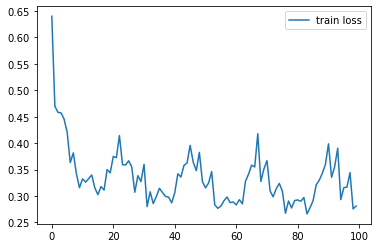

In [23]:
# 训练集和验证集的损失图
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [31]:
## 模型预测
states_value = model.predict(pre_list)


In [51]:
test_y

array([[ 13.,   6.,  10.],
       [ 50.,  35.,  49.],
       [ 17.,  27.,  17.],
       ...,
       [  9.,  20.,   6.],
       [248., 174., 139.],
       [  5.,   3.,   3.]])

In [34]:
y_pred = np.expm1(states_value)
test_y = np.expm1(pre_target)

In [35]:
### 预测 6.28
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def wmape(y_true, y_pre):
    return np.sum(y_true/np.sum(y_true)*(np.abs((y_pre-y_true)/y_true)))*100


In [41]:
# 只有连续的值做预测
import sys

n_out = 3
for i in range(n_out):
    
    print('The mape of prediction is:', mape(test_y[:,i], y_pred[:,i]))
    print('The wmape of prediction is:', wmape(test_y[:,i], y_pred[:,i]),'/n')
    
    pass


The mape of prediction is: inf
The wmape of prediction is: nan /n
The mape of prediction is: inf
The wmape of prediction is: nan /n
The mape of prediction is: 49.89497375647107
The wmape of prediction is: 19.215468894083884 /n


/home/luban/miniconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/luban/miniconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/luban/miniconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [43]:
m

/home/luban/miniconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/luban/miniconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


nan

In [45]:
mape(test_y[:,1], y_pred[:,1])

/home/luban/miniconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


inf

In [49]:
if 0 in test_y[:,1]:
    print(1)

1


## 定义模型结构

In [95]:
"""
(0) Invalid argument:  indices[76,0] = 245 is not in [0, 37)
报错的原因是因为 进行embedding 时 输入data 中的某一个数 不在 embedding 的范围中

"""

len(np.unique(train_list['res_id']))

37

In [96]:
np.unique(train_list['city_id'])

array([ -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [100]:
 int(np.max(train_list['city_id']))

373

In [38]:
def sparseFeature(feat, feat_num, embed_dim=16):
    """
    create dictionary for sparse feature
    :param feat: feature name
    :param feat_num: the total number of sparse features that do not repeat
    :param embed_dim: embedding dimension
    :return:
    """
    return {'feat': feat, 'feat_num': feat_num, 'embed_dim': embed_dim}


def denseFeature(feat):
    """
    create dictionary for dense feature
    :param feat: dense feature name
    :return:
    """
    return {'feat': feat}

In [39]:
feature_columns = [[denseFeature(feat) for feat in dense_features]] + \
                      [[sparseFeature(feat, len(pre1[feat].unique()), embed_dim=16)
                        for feat in sparse_features]]

In [40]:
feature_columns

[[{'feat': 'request_num'},
  {'feat': 'request_num_2d'},
  {'feat': 'request_num_3d'},
  {'feat': 'request_num_4d'},
  {'feat': 'request_num_5d'},
  {'feat': 'request_num_6d'},
  {'feat': 'request_num_7d'},
  {'feat': 'request_num_7d_avg'},
  {'feat': 'last_week_reqeust_number'}],
 [{'feat': 'p_gender', 'feat_num': 2, 'embed_dim': 16},
  {'feat': 'age_level', 'feat_num': 6, 'embed_dim': 16},
  {'feat': 'businessman', 'feat_num': 2, 'embed_dim': 16},
  {'feat': 'passenger_os_type', 'feat_num': 2, 'embed_dim': 16},
  {'feat': 'city_id', 'feat_num': 371, 'embed_dim': 16},
  {'feat': 'res_id', 'feat_num': 37, 'embed_dim': 16},
  {'feat': 'slide_id', 'feat_num': 2, 'embed_dim': 16},
  {'feat': 'business_id', 'feat_num': 19, 'embed_dim': 16},
  {'feat': 'weekDay', 'feat_num': 1, 'embed_dim': 16},
  {'feat': 'dayOfyear', 'feat_num': 1, 'embed_dim': 16},
  {'feat': 'monthOfyear', 'feat_num': 1, 'embed_dim': 16}]]

In [2]:
class lstm_cell(Layer):
    '''
    lstm 细粒度序列化输入
    '''
    def __init__(self, hidden_units, activation='relu', dropout=0.):
        """
		:param hidden_units: A list. Neural network hidden units.
		:param activation: A string. Activation function of dnn.
		:param dropout: A scalar. Dropout number.
		"""
        super(lstm_cell, self).__init__()
        self.lstm_network = [LSTM(units=unit, activation=activation) for unit in hidden_units]
        self.dropout = Dropout(dropout)

    def call(self, inputs, **kwargs):
        x = inputs
        for lstm in self.lstm_network:
            x = lstm(x)
        x = self.dropout(x)
        return x


class LSTM_Model(keras.Model):
    def __init__(self, feature_columns, hidden_units, pre_data, activation='relu',
                 dnn_dropout=0., embed_reg=1e-4, cross_w_reg=1e-4, cross_b_reg=1e-4):
        """
        Deep&Cross Network
        :param feature_columns: A list. dense_feature_columns + sparse_feature_columns
        :param hidden_units: A list. Neural network hidden units.
        :param activation: A string. Activation function of dnn.
        :param dnn_dropout: A scalar. Dropout of dnn.
        :param embed_reg: A scalar. The regularizer of embedding.
        :param cross_w_reg: A scalar. The regularizer of cross network.
        :param cross_b_reg: A scalar. The regularizer of cross network.
        """

        # Embedding and Stacking Layer
        # 因此需要Embedding操作将高维稀疏特征转化为低维密集型特征
        super(LSTM_Model, self).__init__()
        self.dense_feature_columns, self.sparse_feature_columns = feature_columns
        self.layer_num = len(hidden_units)
        self.embed_layers = {
            'embed_' + str(i): Embedding(input_dim=feat['feat_num'],
                                         input_length=1,
                                         output_dim=feat['embed_dim'],
                                         embeddings_initializer='random_uniform',
                                         embeddings_regularizer=l2(embed_reg))
            for i, feat in enumerate(self.sparse_feature_columns)
        }
        
        # 得到的是某一天的细粒度
        
        self.lstm = lstm_cell(hidden_units, activation, dnn_dropout)
        self.dense_final = Dense(pre_data)

    def call(self, inputs):
        dense_inputs, sparse_inputs = inputs
        sparse_embed = tf.concat([self.embed_layers['embed_{}'.format(i)](sparse_inputs[:, i])
                                  for i in range(sparse_inputs.shape[1])], axis=-1)
        x = tf.concat([sparse_embed, dense_inputs], axis=-1)  # shape [None, 221]
        
        
        total_x = self.lstm(x)
        
        
        outputs = tf.nn.sigmoid(self.dense_final(total_x))
        return outputs

    

NameError: name 'Layer' is not defined